In [1]:
import os
import copy
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from aml_dl.mdn.model.tf_ensemble_mdn_model import EnsambleMDN
from aml_dl.gp.simple_gp import GaussianProcess, kernel

In [2]:
from __future__ import print_function
import numpy as np
from sklearn.model_selection import train_test_split

def next_batch(x_data, y_data, batch_size):
    num_examples = x_data.shape[0]
    start = 0
    end = start + batch_size

    # Shuffle the data
    perm = np.arange(num_examples)
    np.random.shuffle(perm)
    xx_data = x_data[perm].copy()
    yy_data = y_data[perm].copy()

    return xx_data[start:end], yy_data[start:end]

def build_1d_mdn_toy_dataset(N):
    y_data = np.random.uniform(-10.5, 10.5, N)
    r_data = np.random.normal(size=N)  # random noise
    x_data = np.sin(0.75 * y_data) * 7.0 + y_data * 0.5 + r_data * 1.0
    x_data = x_data.reshape((N, 1))
    y_data = y_data.reshape((N, 1))
    return train_test_split(x_data, y_data, random_state=42)

def print_all_data(x_train, y_train, x_test, y_test):
    print(" Size of features in training data: {}".format(x_train.shape))
    print(" Size of output in training data: {}".format(y_train.shape))
    print(" Size of features in test data: {}".format(x_test.shape))
    print(" Size of output in test data: {}".format(y_test.shape))

def sample_from_mixture(x, pred_weights, pred_means, pred_std, amount):
    """Draws samples from mixture model. Returns 2d array with input X and sample from prediction of mixture model."""
    samples = np.zeros((amount, 2))
    n_mix = len(pred_weights[0])
    to_choose_from = np.arange(n_mix)
    for j, (weights, means, std_devs) in enumerate(zip(pred_weights, pred_means, pred_std)):
        index = np.random.choice(to_choose_from, p=weights)
        samples[j, 1] = np.random.normal(means[index], std_devs[index], size=1)
        samples[j, 0] = x[j]
        if j == amount - 1:
            break
    return samples

In [3]:
N = 5000  # number of data points
x_train, x_test, y_train, y_test = build_1d_mdn_toy_dataset(N)
print_all_data(x_train, y_train, x_test, y_test)

 Size of features in training data: (3750, 1)
 Size of output in training data: (3750, 1)
 Size of features in test data: (1250, 1)
 Size of output in test data: (1250, 1)


[   0    2    3 ..., 3746 3747 3748]
(2535, 1)
(2535, 1)


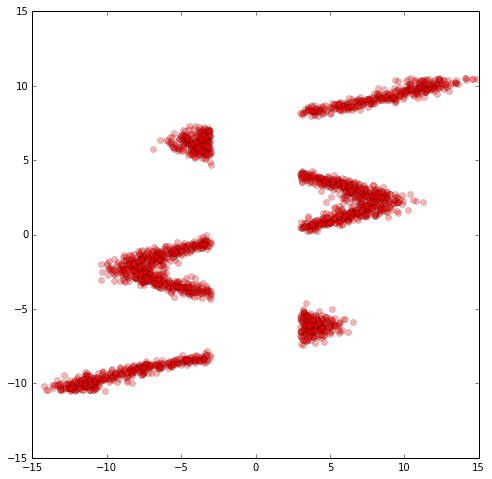

In [4]:
plt.figure(figsize=(8, 8))

indices = np.where( (x_train[:,0] < -3.0) | (x_train[:,0] > 3.0) )
print(indices[0])
x_train = x_train[indices[0],]
y_train = y_train[indices[0],]

print(x_train.shape)
print(y_train.shape)

plt.plot(x_train, y_train,'ro',alpha=0.3)
plt.xlim(-15,15)
plt.ylim(-15,15)
plt.show()

## MDN

In [5]:
EXP_NAME = 'exp_ensemble'

aml_data = '~/.aml_data_tmp'
check_point_dir   = aml_data + '/aml_dl/mdn/tf_check_points/exp_ensemble/'
summary_dir = aml_data + '/aml_dl/mdn/summaries/exp_ensemble/'

if not os.path.exists(check_point_dir):
    os.makedirs(check_point_dir)

if not os.path.exists(summary_dir):
    os.makedirs(summary_dir)

adam_params = {
    'type': 'adam',
    'params': {'learning_rate' : 0.001, 'beta1': 0.9, 'beta2': 0.999, 'epsilon': 1e-08, 'use_locking': False}
}


network_params = {
    'n_ensembles': 5,
    'dim_input': 1, 
    'dim_output': 1,
    'n_hidden': [15,15],
    'k_mixtures': 10,
    'write_summary': False,
    'load_saved_model': False,
    'model_dir': check_point_dir + '/inv/',
    'model_name':'ensemble_model_inv_10_kernels.ckpt',
    'optimiser': adam_params,
    'batch_size': 128,
    'summary_dir':summary_dir+'/inv/',
    'device': '/cpu:0',
    'adv_epsilon': 0.01,
    'adv_batch_size': 64
}

In [6]:
tf.set_random_seed(42)
sess = tf.InteractiveSession()

In [7]:
ensamble_mdn = EnsambleMDN(network_params,sess)
ensamble_mdn._init_model()

In [8]:
iterations = 3000

In [9]:
loss = ensamble_mdn.train(x_train, y_train, sess, iterations)

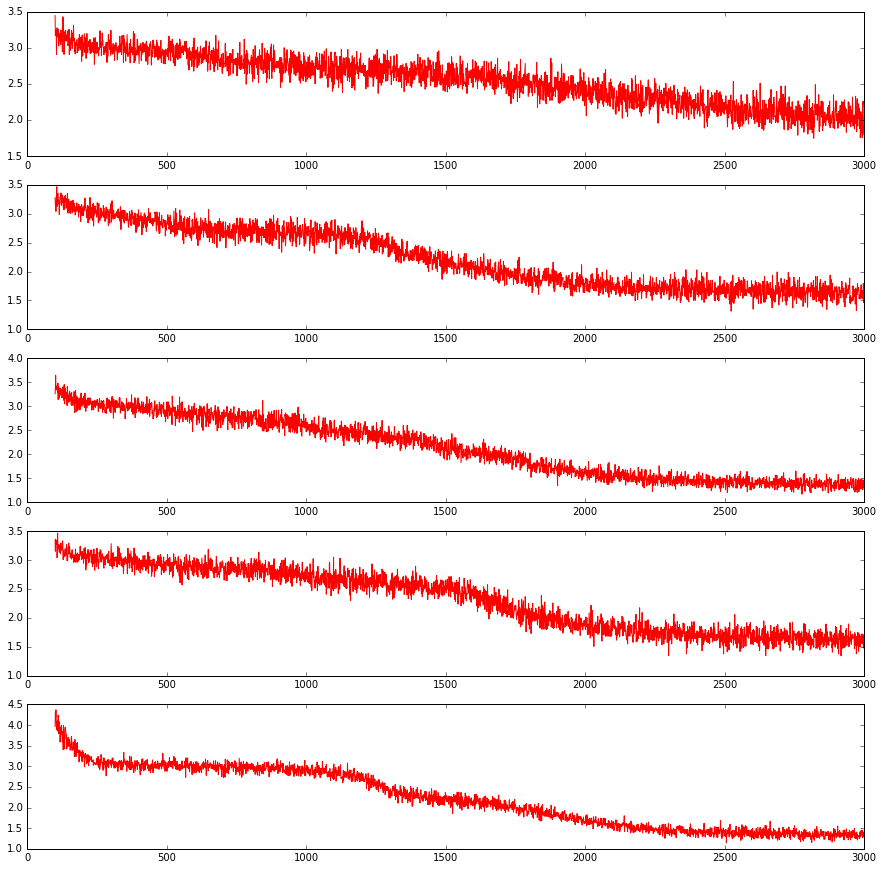

In [10]:
#plot loss curves
plt.figure(figsize=(15,15))
plot_no=network_params['n_ensembles']*100+11
for k in range(network_params['n_ensembles']):
    plt.subplot(plot_no)
    plt.plot(np.arange(100, iterations,1), loss[k, 100:], 'r-')
    plot_no += 1
plt.show()

In [11]:
x_values = np.float32(np.arange(-15, 15, 0.1))
x_test = x_values
print(x_values.shape)

out_mus = ensamble_mdn.run_op(sess, 'mus', np.expand_dims(x_test,axis=1))
out_sigma = ensamble_mdn.run_op(sess, 'sigmas', np.expand_dims(x_test,axis=1))
out_pis = ensamble_mdn.run_op(sess, 'pis', np.expand_dims(x_test,axis=1))

(300,)


In [12]:
mean_out, var_out = ensamble_mdn.forward(sess, np.expand_dims(x_test,axis=1))

In [13]:
def get_pi_idx(x, pdf):
    N = pdf.size
    accumulate = 0
    for i in range(0, N):
        accumulate += pdf[i]
        if (accumulate >= x):
            return i
    print('error with sampling ensemble')
    return -1

def generate_ensemble(out_pi, out_mu, out_sigma, M = 10):
    NTEST = x_test.size
    result = np.random.rand(NTEST, M) # initially random [0, 1]
    mu = 0
    std = 0
    idx = 0

    # transforms result into random ensembles
    for j in range(0, M):
        for i in range(0, NTEST):
            idx = get_pi_idx(result[i, j], out_pi[i])
            mu = out_mu[i, 0, idx]
            std = out_sigma[i, idx]
            result[i, j] = np.random.normal(mu, std, size=1)
    return result

In [14]:
# stddev = 3.

# fig2 = plt.figure(figsize=(8,8))
# ax = fig2.add_subplot(111)

# ypl = [float(mu-stddev*np.sqrt(sig)) for mu,sig in zip(mean_out,var_out)]
# yph = [float(mu+stddev*np.sqrt(sig)) for mu,sig in zip(mean_out,var_out)]

# ax.plot(x_train, y_train,'ro',alpha=0.3)
# ax.fill_between(x_values, ypl, yph, facecolor='grey', interpolate=True, alpha=0.3)
# ax.plot(x_values, mean_out, color='b')
# 
# colours = ['g','c','k','m','y']
# for k in range(network_params['n_ensembles']):
#     ax.plot(x_test, np.reshape(out_mus[k],(np.array(out_mus).shape[1],np.array(out_mus).shape[3])), color=colours[k])
# plt.show()

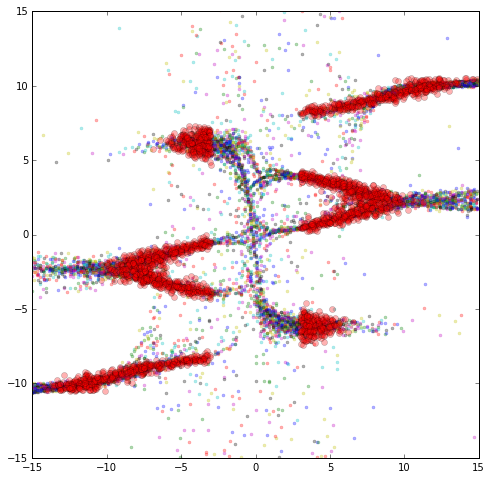

In [15]:
out_mus = np.array(out_mus)
out_sigma = np.array(out_sigma)
out_pis = np.array(out_pis)
# print(out_mus.shape)
# print(out_sigma.shape)
# print(out_pis.shape)

reshaped_out_mus = np.reshape(out_mus, (out_mus.shape[0], out_mus.shape[1], out_mus.shape[3]))
# print(reshaped_out_mus.shape)

fig3 = plt.figure(figsize=(8,8))
ax = fig3.add_subplot(111)

for k in range(5):
    y_sample = generate_ensemble(out_pis[k], out_mus[k], out_sigma[k])
    ax.plot(x_test, y_sample,'.', alpha=0.3)
ax.plot(x_train, y_train, 'ro', alpha=0.3)

plt.xlim(-15,15)
plt.ylim(-15,15)

# for k in range(5):
#     y_sample = generate_ensemble(out_pis[k], out_mus[k], out_sigma[k])
#     plt.figure(figsize=(8, 8))
#     plt.plot(x_train, y_train, 'ro', x_test, y_sample,'o', alpha=0.3)
#     plt.xlim(-15,15)
#     plt.ylim(-15,15)
#     plt.show()
#     print(y_sample.shape)

plt.show()

In [16]:
from scipy import stats
from matplotlib.transforms import Affine2D

def plot_normal_mix(pis, mus, sigmas, ax, label='', comp=True):
    """Plots the mixture of Normal models to axis=ax comp=True plots all components of mixture model"""
    x = np.linspace(-15, 15, 250)
    final = np.zeros_like(x)
    
    base = plt.gca().transData
    rot = Affine2D().rotate_deg(90)

    for i, (weight_mix, mu_mix, sigma_mix) in enumerate(zip(pis, mus, sigmas)):
        temp = stats.norm.pdf(x, mu_mix, sigma_mix) * weight_mix
        final = final + temp
        if comp:
            ax.plot(x, temp, label='Normal ' + str(i), alpha=0.5)
    ax.plot(x, final,linewidth=2, transform=rot+base, alpha=0.5)

def sample_from_mixture(x, pred_weights, pred_means, pred_std, amount):
    """Draws samples from mixture model. Returns 2d array with input X and sample from prediction of mixture model."""
    samples = np.zeros((amount, 2))
    n_mix = len(pred_weights[0])
    to_choose_from = np.arange(n_mix)
    for j, (weights, means, std_devs) in enumerate(zip(pred_weights, pred_means, pred_std)):
        index = np.random.choice(to_choose_from, p=weights)
        samples[j, 1] = np.random.normal(means[index], std_devs[index], size=1)
        samples[j, 0] = x[j]
        if j == amount - 1:
            break
    return samples

-5.32907e-14


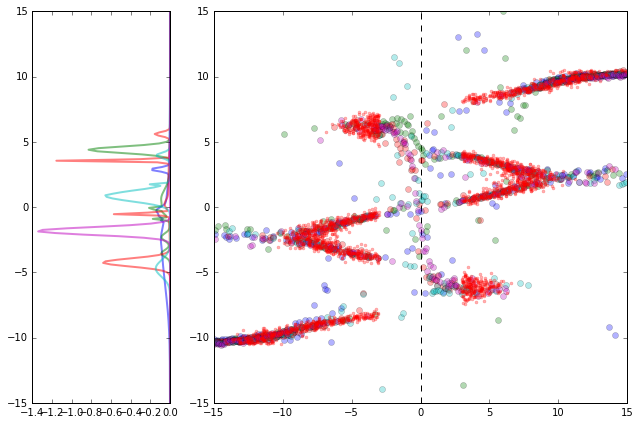

In [18]:
from matplotlib import gridspec

rnd_id = np.random.randint(0, len(x_test))
print(x_test[rnd_id])

fig = plt.figure(figsize=(9, 6))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 3])
ax = plt.subplot(gs[0])

for k in range(5):
    plot_normal_mix(out_pis[k][rnd_id], reshaped_out_mus[k][rnd_id], out_sigma[k][rnd_id], ax, comp=False)

ax2 = plt.subplot(gs[1])

for k in range(5):
    a = sample_from_mixture(x_test, out_pis[k], reshaped_out_mus[k], out_sigma[k], amount=len(x_test))
    ax2.plot(a[:, 0], a[:, 1],'o',alpha=0.3)

ax2.plot(x_train, y_train,'r.',alpha=0.3)
ax2.vlines(x=x_test[rnd_id], ymin=-15, ymax=15, color='k', linestyles='dashed')
ax2.set_xlim(-15,15)
ax2.set_ylim(-15,15)

plt.tight_layout()
plt.show()

In [19]:
x_heatmap_label = np.float32(np.arange(-15,15,0.1))
y_heatmap_label = np.float32(np.arange(-15,15,0.1))

import math
def custom_gaussian(x, mu, std):
    oneDivSqrtTwoPI = 1.0 / math.sqrt(2.0*math.pi)
    x_norm = (x-mu)/std
    result = oneDivSqrtTwoPI*math.exp(-x_norm*x_norm/2.0)/std
    return result

def generate_heatmap(out_pi, out_mu, out_sigma, x_heatmap_label, y_heatmap_label):
    N = x_heatmap_label.size
    M = y_heatmap_label.size
    K = network_params['k_mixtures']
    z = np.zeros((N, M)) # initially random [0, 1]

    mu = 0
    std = 0
    pi = 0    
    # transforms result into random ensembles
    for k in range(0, K):
        for i in range(0, M):
            pi = out_pi[i, k]
            mu = out_mu[i, 0, k]
            std = out_sigma[i, k]
            for j in range(0, N):
                z[N-j-1, i] += pi * custom_gaussian(y_heatmap_label[j], mu, std)
    return z

def draw_heatmap(xedges, yedges, heatmap):
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    plt.figure(figsize=(8, 8))
    plt.imshow(heatmap, extent=extent, interpolation='nearest')
    plt.colorbar()
    plt.show()

In [20]:
z = []
for k in range(5):
    z.append(generate_heatmap(out_pis[k], out_mus[k], out_sigma[k], x_heatmap_label, y_heatmap_label))

In [21]:
print(out_pis[0].shape)
print(out_mus[0].shape)
print(out_sigma[0].shape)
print(x_heatmap_label.size)
print(y_heatmap_label.size)

# for k in range(5):
#     draw_heatmap(x_heatmap_label, y_heatmap_label, z[k])

(300, 10)
(300, 1, 10)
(300, 10)
300
300


In [22]:
z = np.array(z)
print(z.shape)
zz = np.mean(z, axis=0) # Should be product of probability distributions...
print(zz.shape)

(5, 300, 300)
(300, 300)


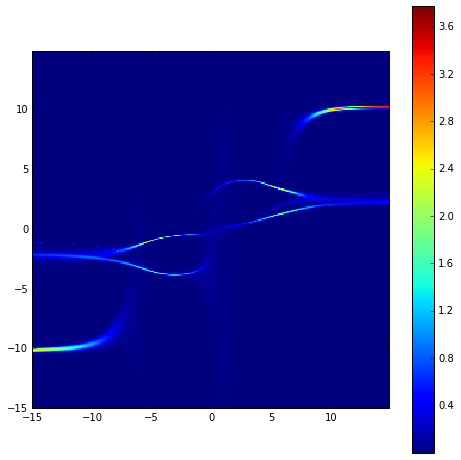

In [23]:
draw_heatmap(x_heatmap_label, y_heatmap_label, z[0])

# Gaussian Process
NOTE: 
* Prediction is unimodal
* Large numbers of data takes time to compute

In [5]:
noise_level = 0.1#0.00000001;
width = 0.5
scale = 30
gp = GaussianProcess(noise_level, width, scale, kernel)

In [6]:
for idx in range(x_train.shape[0]):
    gp.update(x_train[idx,:], y_train[idx,:])

In [7]:
x_values = np.float32(np.arange(-20.0,20.0, 0.05))
print(x_values.shape)

In [8]:
pred, cov, logp = gp.predict3(x_values)
std = np.sqrt(np.diagonal(cov))

In [9]:
sample_posterior = gp.sample_multivariate(pred, cov, len(pred), 5)

In [12]:
%matplotlib inline
plt.figure(figsize=(8,8))

#plt.errorbar(x_values, pred, yerr=std, fmt='b-', ecolor='g', elinewidth=0.1, linewidth=3.5,alpha=0.3)
#plt.plot(x_values, y_values, 'dodgerblue', linewidth=3.0)

plt.plot(x_values, pred, 'b-', linewidth=3.0, alpha=0.3)
plt.fill_between(x_values, pred[:,0]-std, pred[:,0]+std, color='g', alpha=0.2)

plt.plot(x_values, sample_posterior)
plt.plot(gp.x, gp.y, 'ro',alpha=0.3)